# random forest prediction + clustering -ET_project(original 




In [1]:
pip install basemap basemap-data-hires


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [15]:
df= pd.read_csv('/home/antqua/code/AntQua/ET_Predictor/raw_data/scrubbed.csv', low_memory=False)

In [18]:
df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [16]:
df.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object

In [19]:
df['country'].fillna('us', inplace=True)
df = df[~df['country'].isin(['gb', 'ca', 'au', 'de'])]
country_counts = df['country'].value_counts()
print(country_counts)

country
us    74784
Name: count, dtype: int64


/tmp/ipykernel_94893/1224843442.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['country'].fillna('us', inplace=True)


In [21]:
def clean_data(value):
    try:
        # Attempt to convert directly
        return float(value)
    except ValueError:
        # Remove non-numeric characters and try conversion
        cleaned_value = ''.join(char for char in value if char.isdigit() or char == '.')
        try:
            return float(cleaned_value)
        except ValueError:
            # If conversion fails, return NaN
            return float('nan')
            
df['latitude']=df['latitude'].apply(clean_data)
df['longitude ']=df['longitude '].apply(clean_data)
#https://www.quora.com/What-is-the-longitude-and-latitude-of-a-bounding-box-around-the-continental-United-States
df = df[
    (df['longitude '] >= -124.67) & 
    (df['longitude '] <= -66.95) & 
    (df['latitude'] >= 25.84) & 
    (df['latitude'] <= 49.38)
]

In [23]:
df.shape

(70234, 11)

In [24]:
# Strip whitespace from all column names
df.columns = df.columns.str.strip()

# Convert latitude and longitude to numeric, forcing invalid parsing to NaN
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Convert duration (seconds) to numeric, forcing invalid parsing to NaN
df['duration (seconds)'] = pd.to_numeric(df['duration (seconds)'], errors='coerce')

# Convert datetime column to datetime object
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['datetime'])

# Drop rows with NaN 
df = df.dropna()

print(df.shape)
print(df.columns)
# Verify the conversion
print(df.dtypes)

(67888, 11)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude'],
      dtype='object')
datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
dtype: object


In [26]:
us_data = df[df['country'] == 'us']

us_data.shape

(67888, 11)

In [27]:
us_data.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude'],
      dtype='object')

In [28]:
us_data.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
dtype: object

In [29]:
# Convert 'datetime' to datetime object, coerce errors
us_data['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Extract year, month, day, hour, and minute from datetime
us_data['year'] = us_data['datetime'].dt.year
us_data['month'] = us_data['datetime'].dt.month
us_data['day'] = us_data['datetime'].dt.day
us_data['hour'] = us_data['datetime'].dt.hour
us_data['minute'] = us_data['datetime'].dt.minute

In [30]:
us_data.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
year                             int32
month                            int32
day                              int32
hour                             int32
minute                           int32
dtype: object

In [31]:
us_data.isna().sum()

datetime                0
city                    0
state                   0
country                 0
shape                   0
duration (seconds)      0
duration (hours/min)    0
comments                0
date posted             0
latitude                0
longitude               0
year                    0
month                   0
day                     0
hour                    0
minute                  0
dtype: int64

In [32]:
us_data.shape

(67888, 16)

#### Defining X and y

In [34]:
# Drop rows where datetime could not be converted
us_data.dropna(subset=['datetime'], inplace=True)

# Define features and target variable
X = us_data.drop(columns=['latitude', 'longitude'])
y = us_data[['latitude', 'longitude']]


In [35]:
# Define features and target variables
features = ['duration (seconds)', 'year', 'month', 'day', 'hour', 'minute']
X = us_data[features]
y_lat = us_data['latitude']
y_long = us_data['longitude']

# Split the data into training and test sets
X_train, X_test, y_lat_train, y_lat_test, y_long_train, y_long_test = train_test_split(X, y_lat, y_long, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor models
rf_reg_lat = RandomForestRegressor(random_state=42)
rf_reg_lat.fit(X_train_scaled, y_lat_train)

rf_reg_long = RandomForestRegressor(random_state=42)
rf_reg_long.fit(X_train_scaled, y_long_train)

RandomForestRegressor(random_state=42)

In [36]:
# Predict and evaluate the models
y_lat_pred_rf = rf_reg_lat.predict(X_test_scaled)
y_long_pred_rf = rf_reg_long.predict(X_test_scaled)

mae_lat_rf = median_absolute_error(y_lat_test, y_lat_pred_rf)
mae_long_rf = median_absolute_error(y_long_test, y_long_pred_rf)

mae_results = {
    'Random Forest Latitude MAE': mae_lat_rf,
    'Random Forest Longitude MAE': mae_long_rf,
}

mae_results

{'Random Forest Latitude MAE': 3.577620432000021,
 'Random Forest Longitude MAE': 14.520434782500026}

In [37]:
# Example prediction for a future chosen date
future_date = pd.to_datetime('2025-06-01 00:00:00')
future_duration = 120  # example duration in seconds

future_features = pd.DataFrame({
    'duration (seconds)': [future_duration],
    'year': [future_date.year],
    'month': [future_date.month],
    'day': [future_date.day],
    'hour': [future_date.hour],
    'minute': [future_date.minute]
})

future_features_scaled = scaler.transform(future_features)

# Predict latitude and longitude using both models
predicted_lat_rf = rf_reg_lat.predict(future_features_scaled)
predicted_long_rf = rf_reg_long.predict(future_features_scaled)

predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

print(f"Predicted location (Random Forest): {predicted_location_rf}")

Predicted location (Random Forest): (40.37123584466665, -91.86966945899998)


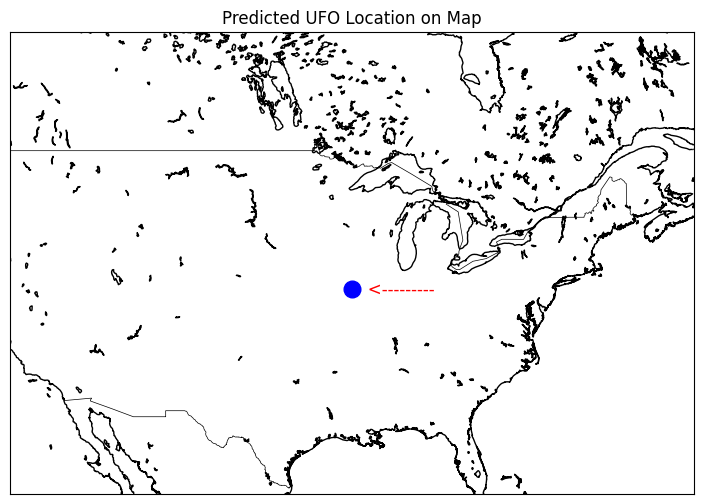

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

predicted_location_rf = (predicted_lat_rf, predicted_long_rf)

# Create a figure
plt.figure(figsize=(15, 6))

# Create a Basemap instance with a larger scale
m = Basemap(projection='merc', llcrnrlat=predicted_lat_rf-15, urcrnrlat=predicted_lat_rf+15,
            llcrnrlon=predicted_long_rf-30, urcrnrlon=predicted_long_rf+30, resolution='i')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert latitude and longitude to map projection coordinates
x, y = m(predicted_long_rf, predicted_lat_rf)

# Plot the predicted location
m.plot(x, y, 'bo', markersize=12)
plt.text(x, y, '   <---------', fontsize=12, ha='left', va='center', color='red')

# Add title
plt.title('Predicted UFO Location on Map')

# Show the plot
plt.show()

In [39]:
predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

predicted_location_rf

(40.37123584466665, -91.86966945899998)

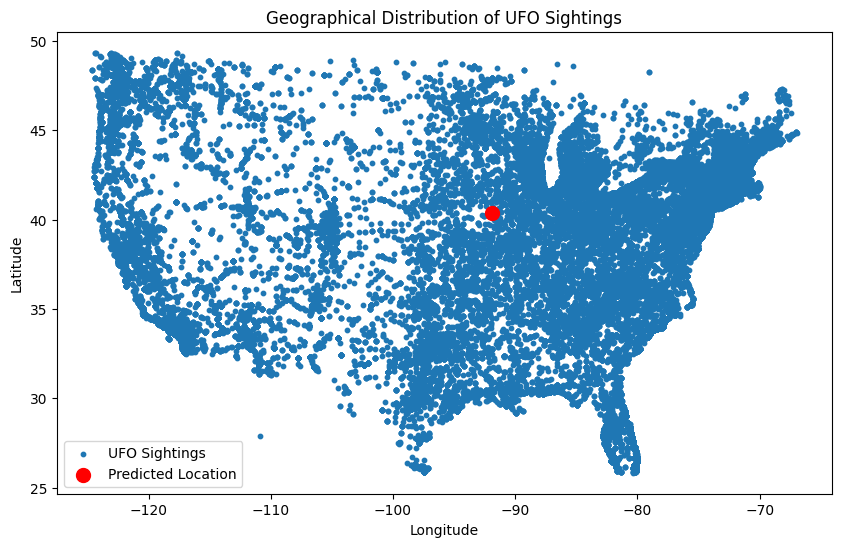

Predicted Cluster: 4
Most Common UFO Shape: light
Average Duration of UFO Sighting: 1363.51 seconds
--------------------------------------------------

Five Sightings Nearest to the Predicted Cluster:
       shape  duration (seconds)
56     light                 8.0
64  triangle                 3.0
71     other              3600.0
83   unknown               600.0
89    sphere               300.0


In [40]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

# Extract relevant features
location_data = us_data[['latitude', 'longitude']]

# Given predicted location
predicted_lat_rf = predicted_lat_rf[0]
predicted_long_rf = predicted_long_rf[0]
predicted_location_rf = {'latitude': predicted_lat_rf, 'longitude': predicted_long_rf}

# Plot the data to understand distribution and include the predicted location
plt.figure(figsize=(10, 6))
plt.scatter(location_data['longitude'], location_data['latitude'], s=10, label='UFO Sightings')
plt.scatter(predicted_long_rf, predicted_lat_rf, color='red', s=100, label='Predicted Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of UFO Sightings')
plt.legend()
plt.show()

# Step 2: Fit the KMeans model
kmeans = KMeans(n_clusters=10, random_state=0) 
kmeans.fit(location_data)

# Add cluster labels to the data
us_data['cluster'] = kmeans.labels_

# Step 3: Predict the cluster for the given location
predicted_point = pd.DataFrame([predicted_location_rf])
predicted_cluster = kmeans.predict(predicted_point)

# Find the cluster for the given location
cluster_label = predicted_cluster[0]

# Step 4: Analyze the cluster
cluster_data = us_data[us_data['cluster'] == cluster_label]

# Predict the most common UFO shape in the cluster
shape_counter = Counter(cluster_data['shape'])
most_common_shape = shape_counter.most_common(1)[0][0]

# Predict the average duration in the cluster
average_duration = cluster_data['duration (seconds)'].mean()

print(f"Predicted Cluster: {cluster_label}")
print(f"Most Common UFO Shape: {most_common_shape}")
print(f"Average Duration of UFO Sighting: {average_duration:.2f} seconds")

print("-" * 50)

# Step 5: Display the shape and duration of the five sightings nearest to the predicted cluster
nearest_sightings = cluster_data[['shape', 'duration (seconds)']].head(5)
print("\nFive Sightings Nearest to the Predicted Cluster:")
print(nearest_sightings)
